**Name:** Muhammad Umer

**Email** umerhayat282@gmail.com

**Date** October 21, 2025

____

# Data Cleaning and Preprocessing

This notebook focuses on handling missing values and duplicate records in the provided datasets.

Objectives:

- Identify and manage missing data using appropriate strategies (e.g., removal, imputation, or replacement).
- Detect and remove duplicate entries to ensure data integrity and consistency.
- Visualize data distributions and missing value patterns to gain deeper insights into data quality.

___

## 📑 Table of Contents

1. **Data Cleaning and Preprocessing**
   - 1.1 [Titanic Dataset](#1.1--titanic-dataset)
     - Overview  
     - Observations — Missing Values in Titanic Dataset  
       - A — Embarked (≈0.2% missing)  
       - B — Cabin (≈77% missing)  
       - C — Encode categorical columns  
       - D — Age (≈20% missing)  
       - E — Verification  
     - Outlier Detection and Handling  
     - Summary of Approach  
     - Detailed Explanation  
     - Check Duplicate Values  
   - 1.2 [Salary Dataset](#1.2--salary-dataset)
     - Overview  
     - Outlier Detection and Handling — Salary Dataset  
   - 1.3 [Employee Dataset](#1.3--employee-dataset)
     - Overview  
     - Outlier Detection and Handling — Employee Dataset  
       - A — Fill categorical columns with mode  
       - B — Temporary encoding for KNNImputer  
       - C — Apply KNN Imputation on numeric columns (Age, Salary)  
       - D — Replace imputed values back into original DataFrame  
       - E — Verify results  
     - Missing Value Handling Strategy


___

In [80]:
#importing liabraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder




import warnings
warnings.filterwarnings('ignore')

In [81]:
# Load dataset
df_titanic = pd.read_csv(r'D:\Ai_machine_learning_deep_learning_air_university_lab_islamabad\data\titanic.csv') #i use r to avoid unicode decode error
df_salary = pd.read_csv('D:\Ai_machine_learning_deep_learning_air_university_lab_islamabad\data\Salaries.csv')
df_employee = pd.read_csv('D:\Ai_machine_learning_deep_learning_air_university_lab_islamabad\data\Employee.csv')

## 1.1 — Titanic Dataset

### Overview

In [82]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
df_titanic.isnull().sum() / len(df_titanic) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

### Observations — Missing Values in Titanic Dataset

- The `Age` column has approximately 19.87% missing values, which may impact analyses involving age-related insights.
- The `Cabin` column has the highest proportion of missing data (~77.10%), indicating cabin info is largely absent.
- The `Embarked` column has a very small percentage of missing values (~0.22%), which can be easily managed.
- All other columns (`PassengerId`, `Survived`, `Pclass`, `Name`, `Sex`, `SibSp`, `Parch`, `Ticket`, `Fare`) have complete data.

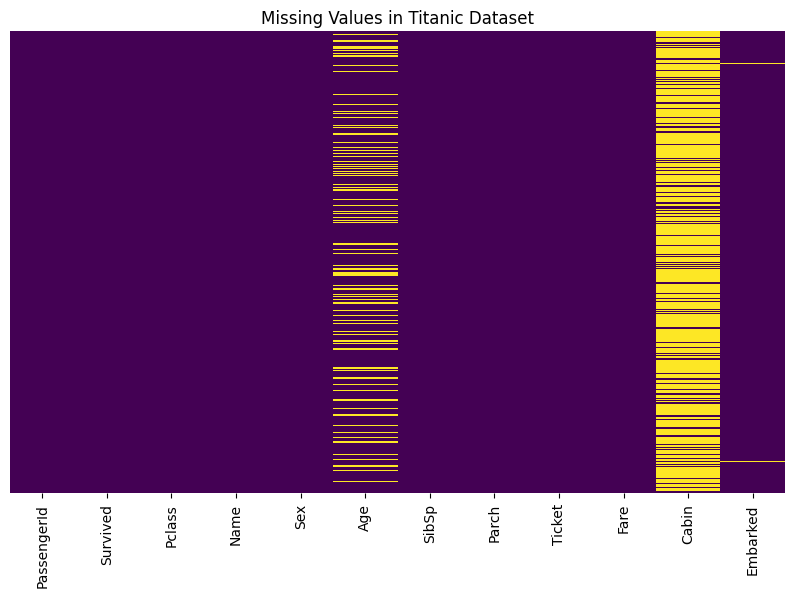

In [84]:
#lets visualize the missing values in the titanic dataset
plt.figure(figsize=(10,6))
sns.heatmap(df_titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing Values in Titanic Dataset')
plt.show()

#### A — Embarked (≈0.2% missing)

Mode imputation

In [85]:
df_titanic['Embarked'].fillna(df_titanic['Embarked'].mode()[0],inplace=True)

#### B — Cabin (≈77% missing)

Extract deck letter and drop the original `Cabin` column to salvage useful information.

In [86]:
df_titanic['Deck'] = df_titanic['Cabin'].apply(lambda x: x[0] if pd.notna(x) else np.nan)
df_titanic.drop(columns=['Cabin'], inplace=True)

#### C — Encode categorical columns

(Temporary label encoding — required because KNNImputer needs numeric input)

In [87]:
label_cols = ['Sex','Embarked','Deck']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_titanic[col] = df_titanic[col].astype(str)  # Ensure all data is string type
    df_titanic[col] = le.fit_transform(df_titanic[col])
    label_encoders[col] = le

#### D — Age (≈20% missing)

KNN Imputation using similar passengers

In [88]:
#select numeric features for relevant for prediction
impute_features = ['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']
imputer = KNNImputer(n_neighbors=5)
df_titanic[impute_features] = imputer.fit_transform(df_titanic[impute_features])

#### E — Verification

Verify no remaining missing values and visualize the result.

In [89]:
#lets verify if there are any missing values left
print("\n✅ Missing values after handling:\n", df_titanic.isnull().mean() * 100)


✅ Missing values after handling:
 PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
Deck           0.0
dtype: float64


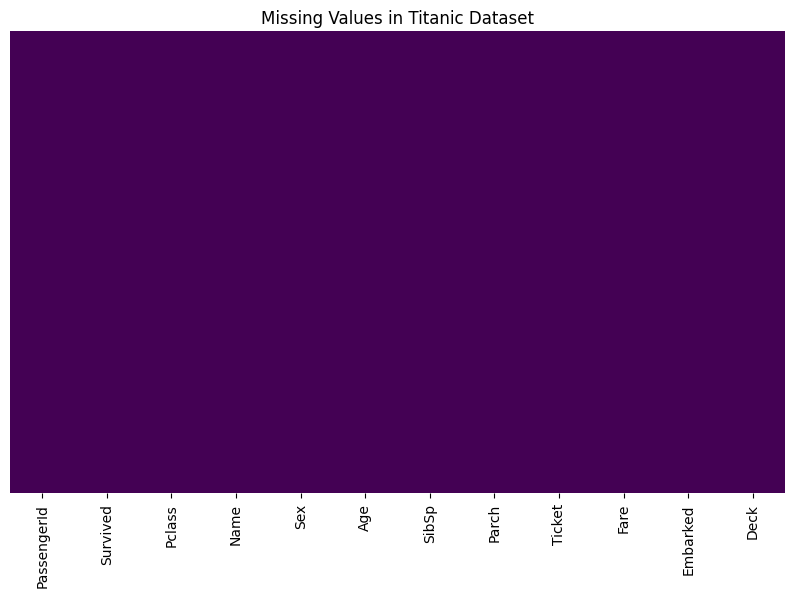

In [90]:
#lets visualize missing values
plt.figure(figsize=(10,6))
sns.heatmap(df_titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing Values in Titanic Dataset')
plt.show()

### Outlier Detection and Handling

Overview:

- Detect outliers in numerical features (Age, Fare) using the IQR method.
- Handle outliers by capping (winsorizing) to IQR bounds to preserve dataset rows.
- Visualize before/after and report counts of affected values.

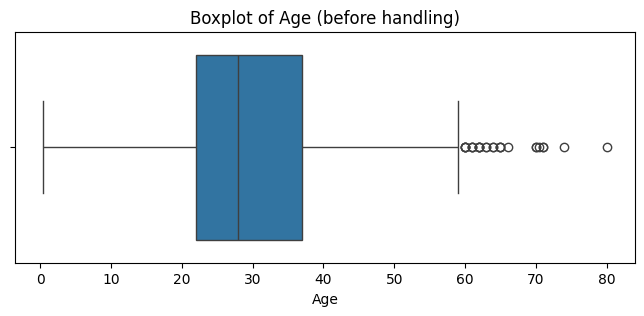

Age: lower=-0.500, upper=59.500, outliers=26
Age: capped 26 values



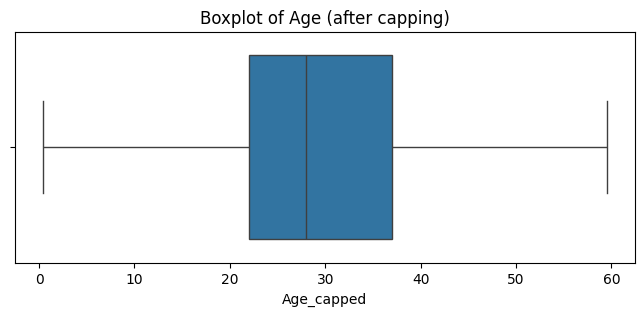

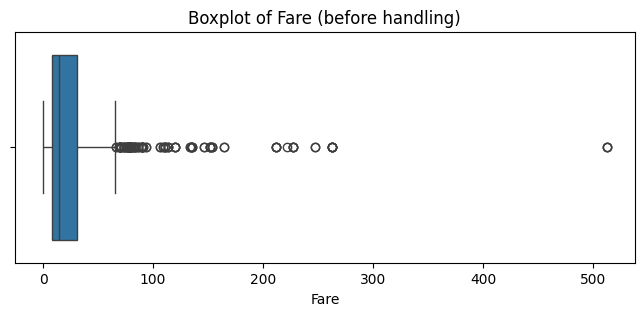

Fare: lower=-26.724, upper=65.634, outliers=116
Fare: capped 116 values



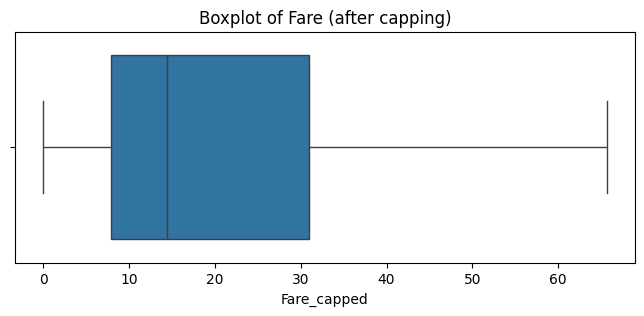


✅ Outlier handling completed for Age and Fare (IQR capping applied).


In [118]:
# Outlier detection and handling for 'Age' and 'Fare' using IQR capping
cols = ['Age', 'Fare']

for col in cols:
    # visualize before handling
    plt.figure(figsize=(8,3))
    sns.boxplot(x=df_titanic[col])
    plt.title(f'Boxplot of {col} (before handling)')
    plt.show()

    # compute IQR bounds
    Q1 = df_titanic[col].quantile(0.25)
    Q3 = df_titanic[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # report number of outliers
    outliers_count = ((df_titanic[col] < lower) | (df_titanic[col] > upper)).sum()
    print(f"{col}: lower={lower:.3f}, upper={upper:.3f}, outliers={outliers_count}")

    # cap values to bounds (winsorize) and keep a copy for comparison
    capped_col = col + '_capped'
    df_titanic[capped_col] = df_titanic[col].clip(lower, upper)

    # report how many values were changed (capped)
    capped_count = (df_titanic[col] != df_titanic[capped_col]).sum()
    print(f"{col}: capped {capped_count} values\n")

    # visualize after handling
    plt.figure(figsize=(8,3))
    sns.boxplot(x=df_titanic[capped_col])
    plt.title(f'Boxplot of {col} (after capping)')
    plt.show()

# Replace original columns with capped versions to finalize handling
df_titanic[cols] = df_titanic[[c + '_capped' for c in cols]]
# drop the auxiliary capped columns (they were copied back, so safe to drop if present)
for c in cols:
    cap = c + '_capped'
    if cap in df_titanic.columns:
        df_titanic.drop(columns=[cap], inplace=True)

print('\n✅ Outlier handling completed for Age and Fare (IQR capping applied).')

### Summary of Approach

- Low missing % (<5%) → Mode/Mean imputation.
- Moderate missing % (5–30%) → Use KNN or ML-based imputation.
- High missing % (>60%) → Drop or extract useful sub-features.

### Detailed Explanation

| Step | Feature | Technique | Why |
|------|----------|-----------|-----|
| A | Embarked | Mode imputation | <1% missing, safe simple fill |
| B | Cabin | Extract deck letter | 77% missing — salvage useful info |
| C | Categorical encoding | LabelEncoder | KNN needs numeric input |
| D | Age | KNNImputer (k=5) | Preserves relationships between passengers | 
| E | Verification | Check missing % | Ensures no nulls remain |

### Check Duplicate Values

In [91]:
#lets check duplicate values
duplicate_titanic = df_titanic.duplicated().sum()
print(f"Number of duplicate values in Titanic dataset: {duplicate_titanic}")

Number of duplicate values in Titanic dataset: 0


___

## 1.2 — Salary Dataset

### Overview

In [92]:
df_salary.head()

,rank,discipline,phd,service,sex,salary
0,Prof,B,56,49,Male,186960
1,Prof,A,12,6,Male,93000
2,Prof,A,23,20,Male,110515
3,Prof,A,40,31,Male,131205
4,Prof,B,20,18,Male,104800


In [93]:
#checking missing values in salary dataset
df_salary.isnull().sum() / len(df_salary) * 100

rank          0.0
discipline    0.0
phd           0.0
service       0.0
sex           0.0
salary        0.0
dtype: float64

In [94]:
#checking duplicate values in salary dataset
duplicate_salary = df_salary.duplicated().sum()
print(f"Number of duplicate values in Salary dataset: {duplicate_salary}")

Number of duplicate values in Salary dataset: 0


In [111]:
df_salary.head()

,rank,discipline,phd,service,sex,salary
0,Prof,B,56,49,Male,186960
1,Prof,A,12,6,Male,93000
2,Prof,A,23,20,Male,110515
3,Prof,A,40,31,Male,131205
4,Prof,B,20,18,Male,104800


In [116]:
#checking inconsistency in the salary dataset by checking unique values in each column but onnly categorical columns
for col in df_salary.select_dtypes(include=['object']).columns:
    unique_values = df_salary[col].unique()
    print(f"Unique values in column '{col}': {unique_values}\n")
    print("--------------------------------------------------")


Unique values in column 'rank': ['Prof' 'AssocProf' 'AsstProf']

--------------------------------------------------
Unique values in column 'discipline': ['B' 'A']

--------------------------------------------------
Unique values in column 'sex': ['Male' 'Female']

--------------------------------------------------


### Outlier Detection and Handling — Salary Dataset

Overview:
- Detect outliers in numeric salary-related features using the IQR method.
- Handle outliers by capping (winsorizing) to IQR bounds to preserve rows.
- Visualize before/after and report counts of affected values.

Numeric columns detected for outlier handling: ['phd', 'service', 'salary']


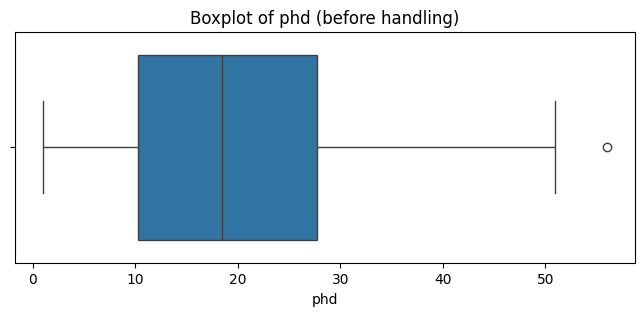

phd: lower=-16.000, upper=54.000, outliers=1
phd: capped 1 values



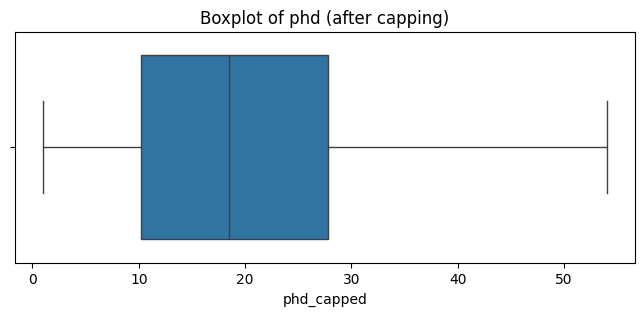

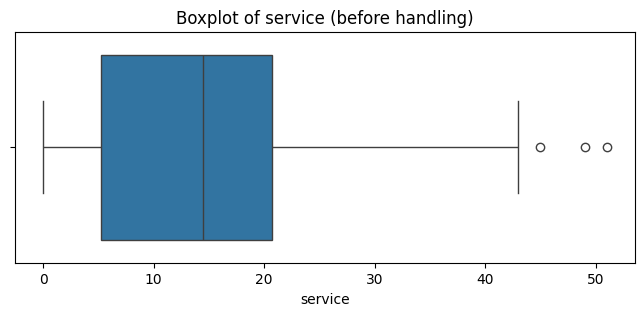

service: lower=-18.000, upper=44.000, outliers=3
service: capped 3 values



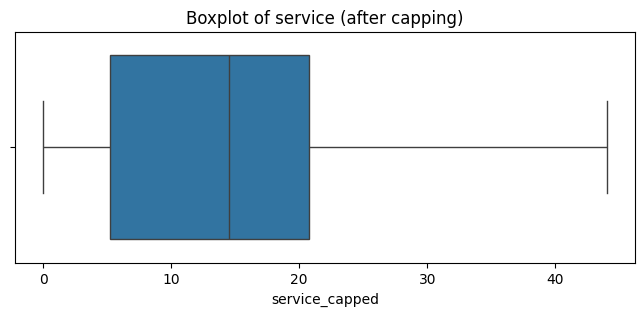

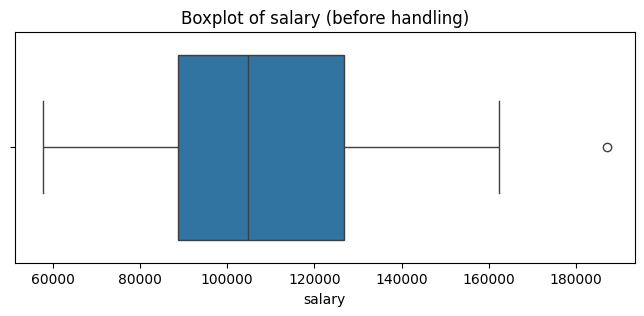

salary: lower=31369.125, upper=184018.125, outliers=1
salary: capped 1 values



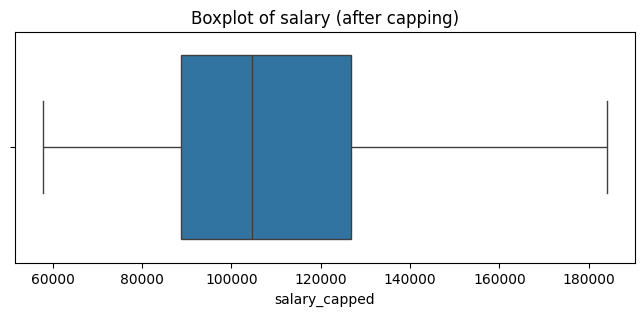


✅ Outlier handling completed for numeric columns in Salary dataset (IQR capping applied).


In [119]:
# Outlier detection and handling for numeric columns in df_salary using IQR capping
num_cols = df_salary.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns detected for outlier handling:', num_cols)

capped_cols = []
for col in num_cols:
    # Visualize before handling
    plt.figure(figsize=(8,3))
    sns.boxplot(x=df_salary[col].dropna())
    plt.title(f'Boxplot of {col} (before handling)')
    plt.show()

    # Compute IQR bounds
    Q1 = df_salary[col].quantile(0.25)
    Q3 = df_salary[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Count outliers
    outliers_count = ((df_salary[col] < lower) | (df_salary[col] > upper)).sum()
    print(f"{col}: lower={lower:.3f}, upper={upper:.3f}, outliers={outliers_count}")

    # Cap (winsorize) values to bounds and store capped column
    capped_col = col + '_capped'
    df_salary[capped_col] = df_salary[col].clip(lower, upper)
    capped_cols.append(capped_col)

    # Report how many values were changed (capped)
    capped_count = (df_salary[col] != df_salary[capped_col]).sum()
    print(f"{col}: capped {capped_count} values\n")

    # Visualize after handling
    plt.figure(figsize=(8,3))
    sns.boxplot(x=df_salary[capped_col].dropna())
    plt.title(f'Boxplot of {col} (after capping)')
    plt.show()

# Replace original numeric columns with capped versions
for orig, cap in zip(num_cols, capped_cols):
    df_salary[orig] = df_salary[cap]
    df_salary.drop(columns=[cap], inplace=True)

print('\n✅ Outlier handling completed for numeric columns in Salary dataset (IQR capping applied).')

___

## 1.3 — Employee Dataset

### Overview

In [95]:
df_employee.head()

,Company,Age,Salary,Place,Country,Gender
0,TCS,20.0,NaN,Chennai,India,0
1,Infosys,30.0,NaN,Mumbai,India,0
2,TCS,35.0,2300.0,Calcutta,India,0
3,Infosys,40.0,3000.0,Delhi,India,0
4,TCS,23.0,4000.0,Mumbai,India,0


In [96]:
#checking missing values in salary dataset
print("\n✅ Missing values in Salary Dataset:\n", df_salary.isnull().mean() * 100)


✅ Missing values in Salary Dataset:
 rank          0.0
discipline    0.0
phd           0.0
service       0.0
sex           0.0
salary        0.0
dtype: float64


In [97]:
#checking duplicate values
duplicate_employee = df_employee.duplicated().sum()
print(f"Number of duplicate values in Employee dataset: {duplicate_employee}")

Number of duplicate values in Employee dataset: 4


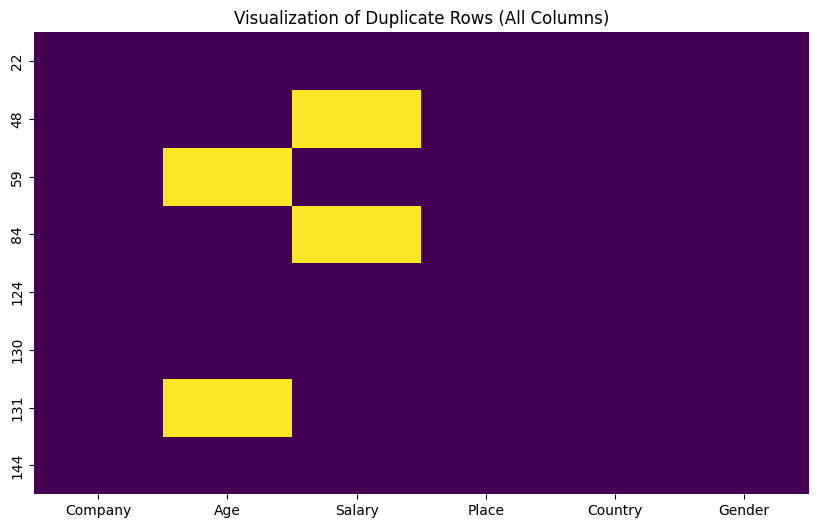

In [98]:
plt.figure(figsize=(10,6))
sns.heatmap(df_employee[df_employee.duplicated(keep=False)].isnull(), 
            cbar=False, cmap='viridis')
plt.title('Visualization of Duplicate Rows (All Columns)')
plt.show()


In [99]:
#remove duplicates
df_employee_cleaned = df_employee.drop_duplicates()
print(f"Number of duplicate values in Employee dataset: {df_employee_cleaned.duplicated().sum()}")

Number of duplicate values in Employee dataset: 0


In [100]:
#verify missing values after removing duplicates
print("\n✅ Missing values in Employee Dataset after removing duplicates:\n", df_employee_cleaned.isnull().mean() * 100)


✅ Missing values in Employee Dataset after removing duplicates:
 Company     5.555556
Age        11.805556
Salary     15.972222
Place       9.722222
Country     0.000000
Gender      0.000000
dtype: float64


### Outlier Detection and Handling — Employee Dataset

Overview:
- Detect outliers in numeric employee-related features (e.g., Age, Salary) using the IQR method.
- Handle outliers by capping (winsorizing) to IQR bounds to preserve rows.
- Visualize before/after and report counts of affected values.

Numeric columns detected (all): ['Age', 'Salary', 'Gender']
Numeric columns considered for outlier handling (nunique>10): ['Age', 'Salary']


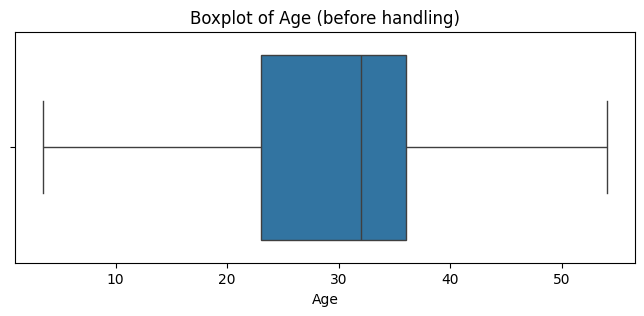

Age: lower=3.500, upper=55.500, outliers=0
Age: capped 0 values



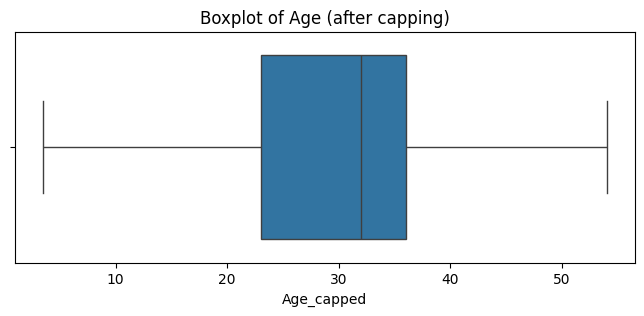

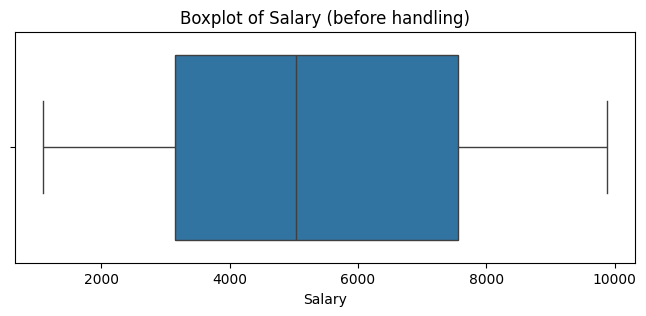

Salary: lower=-3469.575, upper=14180.625, outliers=0
Salary: capped 0 values



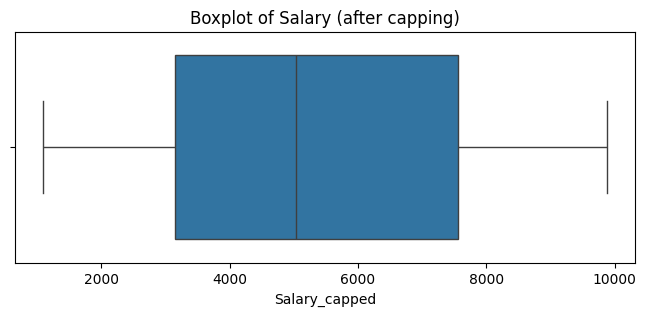


✅ Outlier handling completed for numeric columns in Employee dataset (IQR capping applied).


In [121]:
# Outlier detection and handling for numeric columns in df_employee using IQR capping
numeric_cols = df_employee.select_dtypes(include=[np.number]).columns.tolist()
# Exclude numeric columns that are likely categorical/binary (low cardinality) — adjust threshold if needed
num_cols = [c for c in numeric_cols if df_employee[c].nunique(dropna=True) > 10]
print('Numeric columns detected (all):', numeric_cols)
print('Numeric columns considered for outlier handling (nunique>10):', num_cols)

if not num_cols:
    print('No suitable numeric columns found for outlier detection. Lower the nunique threshold if needed.')
else:
    capped_cols = []
    for col in num_cols:
        # Visualize before handling (skip if all NaN)
        if df_employee[col].dropna().empty:
            print(f"{col}: no non-null values to analyze. Skipping.")
            continue

        plt.figure(figsize=(8,3))
        sns.boxplot(x=df_employee[col].dropna())
        plt.title(f'Boxplot of {col} (before handling)')
        plt.show()

        # Compute IQR bounds
        Q1 = df_employee[col].quantile(0.25)
        Q3 = df_employee[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Count outliers
        outliers_count = ((df_employee[col] < lower) | (df_employee[col] > upper)).sum()
        print(f"{col}: lower={lower:.3f}, upper={upper:.3f}, outliers={outliers_count}")

        # Cap (winsorize) values to bounds and store capped column
        capped_col = col + '_capped'
        df_employee[capped_col] = df_employee[col].clip(lower, upper)
        capped_cols.append(capped_col)

        # Report how many values were changed (capped)
        capped_count = (df_employee[col] != df_employee[capped_col]).sum()
        print(f"{col}: capped {capped_count} values\n")

        # Visualize after handling
        plt.figure(figsize=(8,3))
        sns.boxplot(x=df_employee[capped_col].dropna())
        plt.title(f'Boxplot of {col} (after capping)')
        plt.show()

    # Replace original numeric columns with capped versions (only those processed)
    for orig, cap in zip(num_cols, capped_cols):
        df_employee[orig] = df_employee[cap]
        df_employee.drop(columns=[cap], inplace=True)

    print('\n✅ Outlier handling completed for numeric columns in Employee dataset (IQR capping applied).')

#### A — Fill categorical columns with mode

In [101]:
df_employee['Company'].fillna(df_employee['Company'].mode()[0], inplace=True)
df_employee['Place'].fillna(df_employee['Place'].mode()[0], inplace=True)

#### B — Temporary encoding for KNNImputer

In [102]:
df_encoded = df_employee.copy()
df_encoded['Company'] = df_encoded['Company'].astype('category').cat.codes
df_encoded['Place'] = df_encoded['Place'].astype('category').cat.codes
df_encoded['Gender'] = df_encoded['Gender'].astype('category').cat.codes
df_encoded['Country'] = df_encoded['Country'].astype('category').cat.codes

#### C — Apply KNN Imputation on numeric columns (Age, Salary)

In [103]:
imputer = KNNImputer(n_neighbors=5)
df_encoded[['Age', 'Salary']] = imputer.fit_transform(df_encoded[['Age', 'Salary']])

#### D — Replace imputed values back into original DataFrame

In [104]:
df_employee['Age'] = df_encoded['Age']
df_employee['Salary'] = df_encoded['Salary']

#### E — Verify results

In [105]:
print("✅ Missing values after imputation:")
print(df_employee.isnull().mean() * 100)

✅ Missing values after imputation:
Company    0.0
Age        0.0
Salary     0.0
Place      0.0
Country    0.0
Gender     0.0
dtype: float64


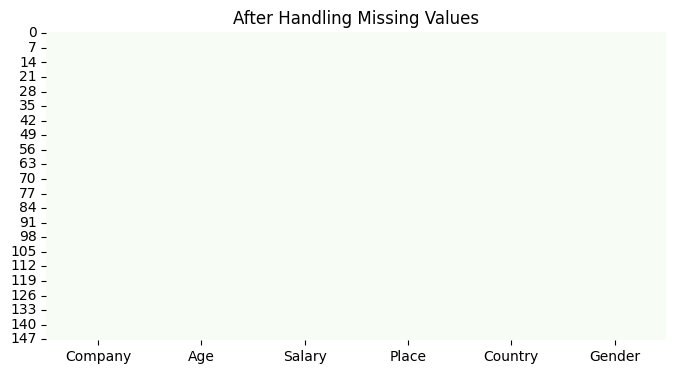

In [106]:

# After imputation
plt.figure(figsize=(8,4))
sns.heatmap(df_employee.isnull(), cbar=False, cmap='Greens')
plt.title("After Handling Missing Values")
plt.show()

### Missing Value Handling Strategy

| **Column** | **Missing %** | **Data Type** | **Handling Technique** | **Reason / Explanation** |
|-------------|----------------|----------------|-------------------------|----------------------------|
| Company | 5.56% | Categorical | Filled with **mode (most frequent)** | Few missing values, simple mode preserves data consistency. |
| Age | 11.81% | Numerical | **KNN Imputer (k=5)** | Predicts missing ages using similarity between employees (more accurate than mean/median). |
| Salary | 15.97% | Numerical | **KNN Imputer (k=5)** | Estimates missing salaries using related features (Age, Company, Place). |
| Place | 9.72% | Categorical | Filled with **mode (most frequent)** | Limited missing data, mode imputation maintains category balance. |
| Country | 0.00% | Categorical | No action needed | No missing values present. |
| Gender | 0.00% | Categorical | No action needed | Complete data, no imputation required. |

---

✅ **Summary:**  
Numeric columns with moderate missingness were imputed using **KNN Imputer (k=5)** to retain natural relationships,  
while categorical columns with low missing percentages were filled using the **most frequent category** to maintain data integrity.


___